In [1]:
# Phần 1: Import và khởi tạo Spark Session
import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, RandomForestClassifier

# Khởi tạo Spark Session
spark = SparkSession.builder \
    .appName("Sentiment Analysis Training") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
    
# Kiểm tra SparkSession
spark

In [3]:
# Phần 2: Hàm load dữ liệu
def load_data(embedding_name):
    """Load dữ liệu từ các file parquet"""
    path = "C:/Users/vmcch/BIGDATA/sentiment_analysis_project/data/processed/"
    train_df = spark.read.parquet(f"{path}train/{embedding_name}.parquet")
    val_df = spark.read.parquet(f"{path}validation/{embedding_name}.parquet")
    test_df = spark.read.parquet(f"{path}test/{embedding_name}.parquet")
    
    # Đổi tên cột embedding thành features để đồng nhất với MLlib
    train_df = train_df.withColumnRenamed("embedding", "features")
    val_df = val_df.withColumnRenamed("embedding", "features")
    test_df = test_df.withColumnRenamed("embedding", "features")
    
    return train_df, val_df, test_df

In [4]:
# Dictionary để lưu trữ tất cả kết quả
results_dict = {
    'Model': [],
    'Embedding': [],
    'Validation Accuracy': [],
    'Test Accuracy': [],
    'Training Time': []
}

In [5]:
def train_and_evaluate(model, model_name, train_df, val_df, test_df, embedding_name):
    """Train mô hình và đánh giá kết quả"""
    print(f"\nTraining {model_name} with {embedding_name}")
    start_time = time.time()
    
    # Train model
    model_fitted = model.fit(train_df)
    
    # Evaluate trên validation set
    val_predictions = model_fitted.transform(val_df)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    val_accuracy = evaluator.evaluate(val_predictions)
    
    # Evaluate trên test set
    test_predictions = model_fitted.transform(test_df)
    test_accuracy = evaluator.evaluate(test_predictions)
    
    training_time = time.time() - start_time
    
    # Lưu kết quả vào dictionary
    results_dict['Model'].append(model_name)
    results_dict['Embedding'].append(embedding_name)
    results_dict['Validation Accuracy'].append(val_accuracy)
    results_dict['Test Accuracy'].append(test_accuracy)
    results_dict['Training Time'].append(training_time)
    
    # In kết quả cho lần chạy hiện tại
    print(f"{model_name} - {embedding_name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    
    return model_fitted

In [6]:
def plot_comparison():
    """Vẽ biểu đồ so sánh tất cả kết quả"""
    # Chuyển dictionary thành DataFrame
    results_df = pd.DataFrame(results_dict)
    
    # Hiển thị bảng tổng hợp
    print("\n=== Summary of All Results ===")
    print(results_df.to_string(index=False))
    
    # Tạo biểu đồ
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Biểu đồ Validation Accuracy
    pivot_val = results_df.pivot(index='Model', columns='Embedding', values='Validation Accuracy')
    pivot_val.plot(kind='bar', ax=ax1)
    ax1.set_title('Validation Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.legend(title='Embedding')
    
    # Thêm giá trị lên trên các cột
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', padding=3)
    
    # Biểu đồ Test Accuracy
    pivot_test = results_df.pivot(index='Model', columns='Embedding', values='Test Accuracy')
    pivot_test.plot(kind='bar', ax=ax2)
    ax2.set_title('Test Accuracy Comparison')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend(title='Embedding')
    
    # Thêm giá trị lên trên các cột
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()
    plt.show()

In [7]:
def main():
    """Hàm chính để chạy toàn bộ quy trình"""
    # List các loại embedding
    embeddings = ["hashingTF", "hashingTFIDF", "w2v"]
    
    for embedding in embeddings:
        # Load dữ liệu
        train_df, val_df, test_df = load_data(embedding)
        
        # Khởi tạo các mô hình
        # Sử dụng cột 'features' (tức embedding) trực tiếp
        lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
        nb = NaiveBayes(featuresCol="features", labelCol="label")
        svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)
        rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
        
        # Danh sách mô hình để train
        models = [
            (lr, "Logistic Regression"),
            (nb, "Naive Bayes"),
            (svm, "SVM"),
            (rf, "Random Forest")
        ]
        
        # Train và evaluate từng mô hình
        for model, model_name in models:
            train_and_evaluate(model, model_name, train_df, val_df, test_df, embedding)


Training Logistic Regression with hashingTF
Logistic Regression - hashingTF
Validation Accuracy: 0.6336
Test Accuracy: 0.6317
Training Time: 8.26 seconds

Training Naive Bayes with hashingTF
Naive Bayes - hashingTF
Validation Accuracy: 0.6293
Test Accuracy: 0.6293
Training Time: 1.75 seconds

Training SVM with hashingTF
SVM - hashingTF
Validation Accuracy: 0.6321
Test Accuracy: 0.6324
Training Time: 5.43 seconds

Training Random Forest with hashingTF
Random Forest - hashingTF
Validation Accuracy: 0.5725
Test Accuracy: 0.5721
Training Time: 7.24 seconds

Training Logistic Regression with hashingTFIDF
Logistic Regression - hashingTFIDF
Validation Accuracy: 0.6336
Test Accuracy: 0.6317
Training Time: 1.57 seconds

Training Naive Bayes with hashingTFIDF
Naive Bayes - hashingTFIDF
Validation Accuracy: 0.6308
Test Accuracy: 0.6294
Training Time: 0.61 seconds

Training SVM with hashingTFIDF
SVM - hashingTFIDF
Validation Accuracy: 0.6321
Test Accuracy: 0.6324
Training Time: 4.17 seconds

Trai

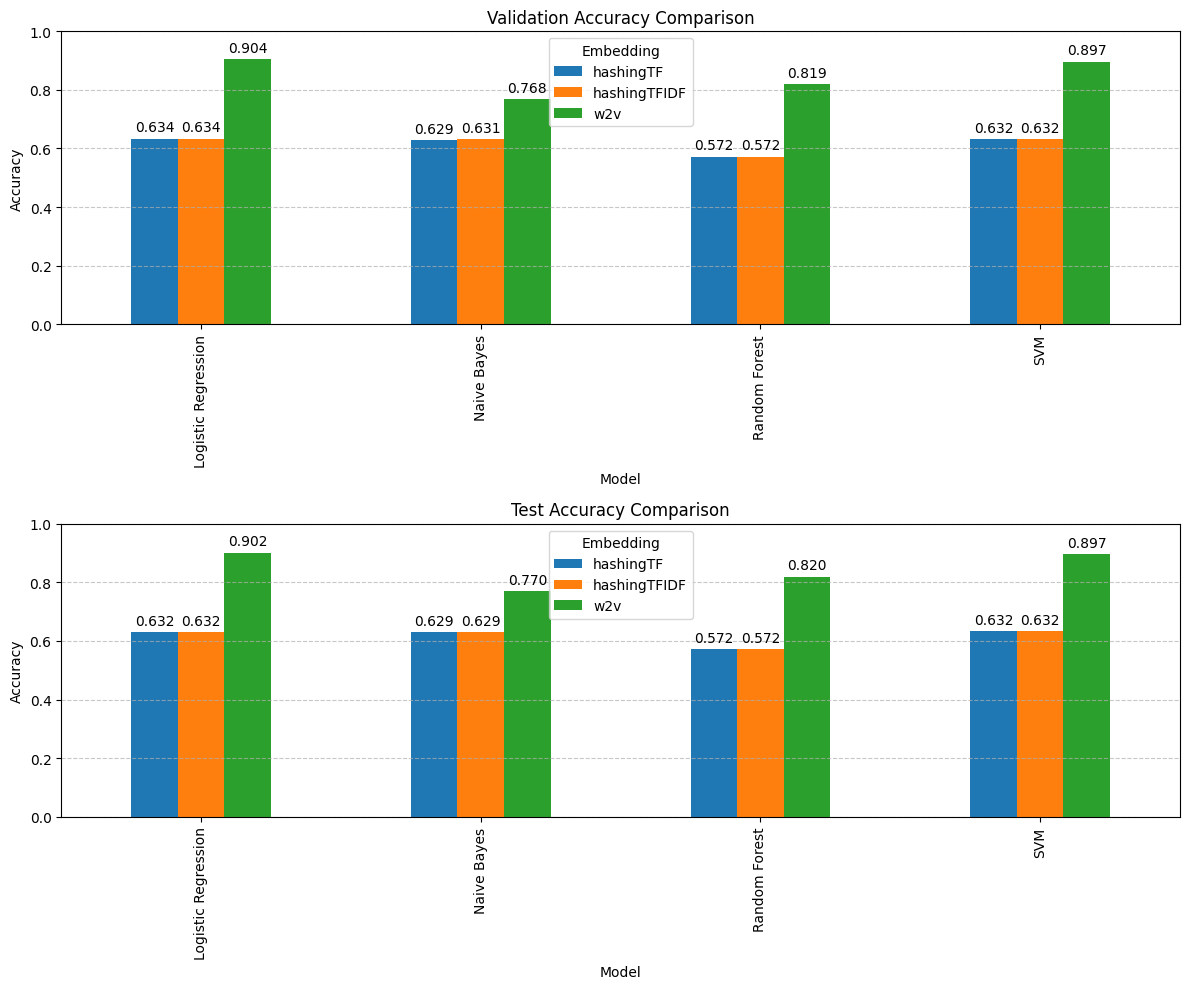

In [8]:
if __name__ == "__main__":
    main()
    plot_comparison()  # Gọi hàm vẽ biểu đồ sau khi train tất cả mô hình
    # Đóng Spark Session khi hoàn thành

In [10]:
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression

# Load dữ liệu với embedding w2v
train_df, val_df, test_df = load_data("w2v")

# Khởi tạo và huấn luyện mô hình Logistic Regression
lr = SparkLogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_df)

# Đánh giá lại mô hình
val_predictions = lr_model.transform(val_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
val_accuracy = evaluator.evaluate(val_predictions)
test_predictions = lr_model.transform(test_df)
test_accuracy = evaluator.evaluate(test_predictions)

print(f"PySpark Logistic Regression with w2v - Validation Accuracy: {val_accuracy:.4f}")
print(f"PySpark Logistic Regression with w2v - Test Accuracy: {test_accuracy:.4f}")

path = "C:/Users/vmcch/BIGDATA/sentiment_analysis_project/"
# Lưu mô hình PySpark
lr_model.save(path + "model/logistic_regression_w2v_spark_model")
print("Model saved as logistic_regression_w2v_spark_model")

PySpark Logistic Regression with w2v - Validation Accuracy: 0.9040
PySpark Logistic Regression with w2v - Test Accuracy: 0.9021
Model saved as logistic_regression_w2v_spark_model


In [11]:
spark.stop()